<a href="https://colab.research.google.com/github/rpdahxn/HandsOnML/blob/main/07_ensemble_learning_and_random_forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# 설정

# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 7.1 투표 기반 분류기

In [4]:
# 동전의 앞면과 뒷면

heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis = 0) / np.arange(1, 10001).reshape(-1, 1)

np.random.rand(10000, 10) : 1000x10 개의 랜덤 수 생성  
np.arange(1, 10001) : 1에서 10000까지의 수를 배열로

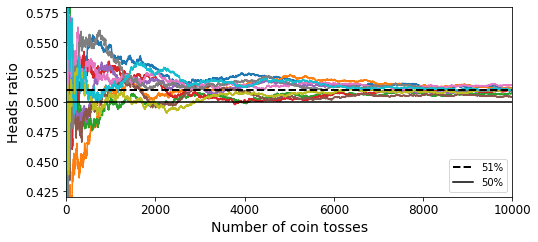

In [5]:
# <그림 7-3. 큰 수의법칙> 생성 코드
plt.figure(figsize = (8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth = 2, label = "51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label = "50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc = "lower right")
plt.axis([0, 10000, 0.42, 0.58])

plt.show()

In [6]:
# moons 데이터셋을 사용해 본다.
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples = 500, noise = 0.30, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [7]:
# 분류기 여러 개 만들기

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver = "lbfgs", random_state = 42)
rnd_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
svm_clf = SVC(gamma = "scale", random_state = 42)

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting = 'hard')

In [8]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [9]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


간접투표  
개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측할 수 있다.  
voting = 'soft'로 바꿔주고 클래스 확률을 알아야 하기 때문에 SVC에서 probability = True로 설정한다.  

In [10]:
log_clf = LogisticRegression(solver = "lbfgs", random_state = 42)
rnd_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
svm_clf = SVC(gamma = "scale", probability = True, random_state = 42)

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting = 'soft'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [11]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


간접 투표 방식이 직접 투표 방식보다 성능이 더 높다.

## 7.2 배깅과 페이스팅  
배깅 : 훈련 세트에서 중복을 허용하여 샘플링하는 방식    
페이스팅 : 중복을 허용하지 않고 샘플링하는 방식   

### 7.2.1 사이킷런의 배깅과 페이스팅

In [12]:
# 결정 트리 분류기 500개의 앙상블을 훈련시키는 코드
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500,
    max_samples = 100, bootstrap = True, random_state = 42)  # 페이스팅이라면 bootstrap = False로 
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [13]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

0.904


In [14]:
# 단일 결정 트리
tree_clf = DecisionTreeClassifier(random_state = 42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


500개의 트리를 사용한 배깅 앙상블의 정확도가 더 높다.

In [15]:
# 위에서 구한 단일 결정 트리와 500개 트리로 만든 배깅 앙상블의 결정 경계 나타내기
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes = [-1.5, 2.45, -1, 1.5], alpha = 0.5, contour = True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha = 0.3, cmap = custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel('$x_1$', fontsize = 18)
    plt.ylabel('$y_1$', fontsize = 18, rotation = 0)

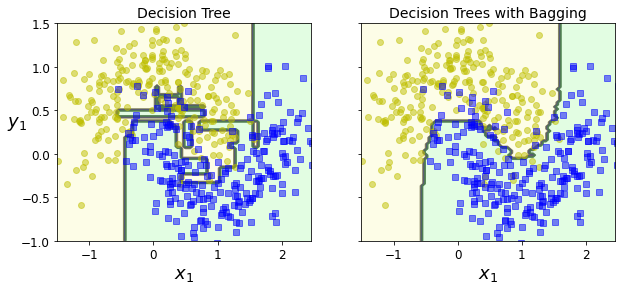

In [16]:
fix, axes = plt.subplots(ncols = 2, figsize = (10, 4), sharey = True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize = 14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize = 14)
plt.ylabel("")

plt.show()

### 7.2.2 oob 평가

In [18]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500,
    bootstrap = True, n_jobs = 1, oob_score = True  # n_jobs는 사용할 cpu 코어 개수
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8933333333333333

oob_score = True로 지정하면 훈련이 끝난 후 자동으로 oob 평가를 수행한다.  
oob 평가 결과를 통해 이 BaggingClassifier가 **테스트 세트에서 약 89.3%의 정확도를 얻을 것으로 보인다.**

In [19]:
# oob 샘플에 대한 결정 함수의 값
# 이 결정 함수는 각 훈련 샘플의 클래스 확률을 반환한다.

bag_clf.oob_decision_function_

array([[0.34536082, 0.65463918],
       [0.4       , 0.6       ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.07303371, 0.92696629],
       [0.4       , 0.6       ],
       [0.01530612, 0.98469388],
       [1.        , 0.        ],
       [0.99428571, 0.00571429],
       [0.76756757, 0.23243243],
       [0.00591716, 0.99408284],
       [0.76966292, 0.23033708],
       [0.80952381, 0.19047619],
       [0.96610169, 0.03389831],
       [0.06936416, 0.93063584],
       [0.00574713, 0.99425287],
       [0.96590909, 0.03409091],
       [0.94736842, 0.05263158],
       [0.98404255, 0.01595745],
       [0.03508772, 0.96491228],
       [0.3715847 , 0.6284153 ],
       [0.8972973 , 0.1027027 ],
       [1.        , 0.        ],
       [0.96590909, 0.03409091],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.75280899, 0.24719101],
       [0.

oob 평가는 첫 번째 훈련 샘플이 양성 클래스에 속할 확률을 65.46%로 추정하고 있다.

In [20]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

## 7.4 랜덤 포레스트

In [21]:
# 이전에는 BaggingClassifier 에 DecisionTreeClassifier를 넣는 방법을 사용했는데
# 대신 결정 트리에 최적화되어 있는 RandomForestClassifier를 사용해 본다.
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [22]:
# 랜덤 포레스트는 결정트리의 배깅과 비슷하다.

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

In [23]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [24]:
np.sum(y_pred == y_pred_rf) / len(y_pred)

1.0

예측이 동일한 것을 확인할 수 있다. 

### 7.4.1 엑스트라 트리  
### 7.4.2 특성 중요도

In [25]:
# iris 데이터셋에 RandomForestClassifier를 훈련시키고 각 특성의 중요도를 출력한다.

from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators = 500, random_state = 42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [26]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

다음 그림은 15개 결정 트리의 결정 경계를 중첩한 것이다. 여기서 볼 수 있듯이 개별 결정 트리는 불완전하지만 앙상블되면 좋은 결정 경계를 만든다.

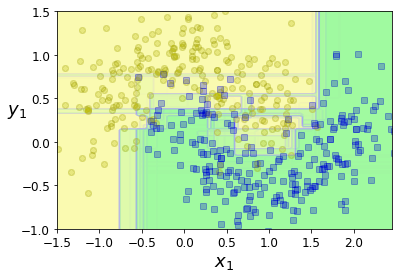

In [27]:
plt.figure(figsize = (6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes = 16, random_state = 42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes = [-1.5, 2.45, -1, 1.5], alpha = 0.02, contour = False)

plt.show()

In [28]:
# MNIST 데이터셋에 랜덤 포레스트 분류기를 훈련시키고 각 픽셀의 중요도를 그래프로 나타내기

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1)
mnist.target = mnist.target.astype(np.uint8)

In [29]:
rnd_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [30]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot, 
    interpolation = "nearest")
    plt.axis("off")

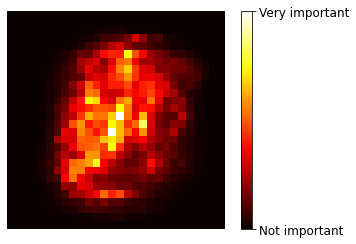

In [31]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks = [rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

# 7.5 부스팅
## 7.5.1 에이다부스트

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth = 1), n_estimators = 200,
    algorithm = "SAMME.R", learning_rate = 0.5, random_state = 42
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

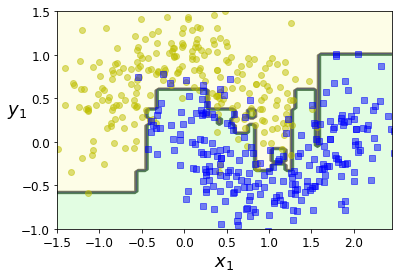

In [ ]:
plot_decision_boundary(ada_clf, X, y)

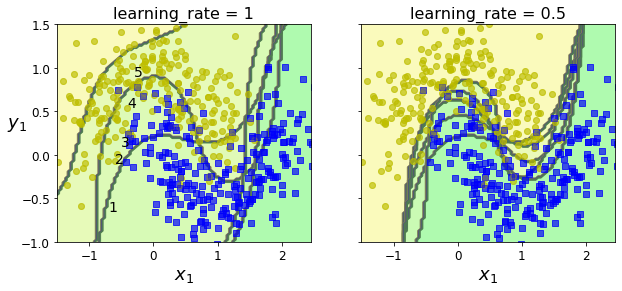

In [ ]:
# <그림 7-8. 연속된 예측기의 결정 경계> 생성 코드

m = len(X_train)

fix, axes = plt.subplots(ncols = 2, figsize = (10, 4), sharey = True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel = "rbf", C = 0.2, gamma = 0.6, random_state = 42)
        svm_clf.fit(X_train, y_train, sample_weight = sample_weights * m)
        y_pred = svm_clf.predict(X_train)
        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum()
        alpha = learning_rate * np.log((1 -r) / r)
        sample_weights[y_pred != y_train] *= np.exp(alpha)  # 잘못 예측한 것에만 적용
        sample_weights /= sample_weights.sum()  # 정규화
        plot_decision_boundary(svm_clf, X, y, alpha = 0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize = 16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()

## 7.5.2 그레이디언트 부스팅

In [ ]:
# 간단한 이차식 형태의 데이터셋을 만든다 

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)

In [ ]:
# 이제 이 데이터셋에 결정 트리 회귀 모델을 훈련시킨다.

from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth = 2, random_state = 42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

첫 번째 예측기에서 생긴 잔여 오차에 두 번째 DecisionTreeRegressor를 훈련시킨다.

In [ ]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth = 2, random_state = 42)
tree_reg2.fit(X, y2)  # 이전에 얻은 잔여 오차로 예측기를 학습한다.

DecisionTreeRegressor(max_depth=2, random_state=42)

In [ ]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth = 2, random_state = 42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [ ]:
X_new = np.array([[0.8]])

In [ ]:
# 새로운 샘플에 대한 예측을 만들려면 모든 트리의 예측을 더한다.

y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [ ]:
y_pred

array([0.75026781])

tree_reg1 , tree_reg2, tree_reg3 를 그래프로 그려본다.

In [ ]:
def plot_predictions(regressors, X, y, axes, label = None, style = "r-", data_style = "b.", data_label = None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label = data_label)
    plt.plot(x1, y_pred, style, linewidth = 2, label = label)
    if label or data_label:
        plt.legend(loc = "upper center", fontsize = 16)
    plt.axis(axes)

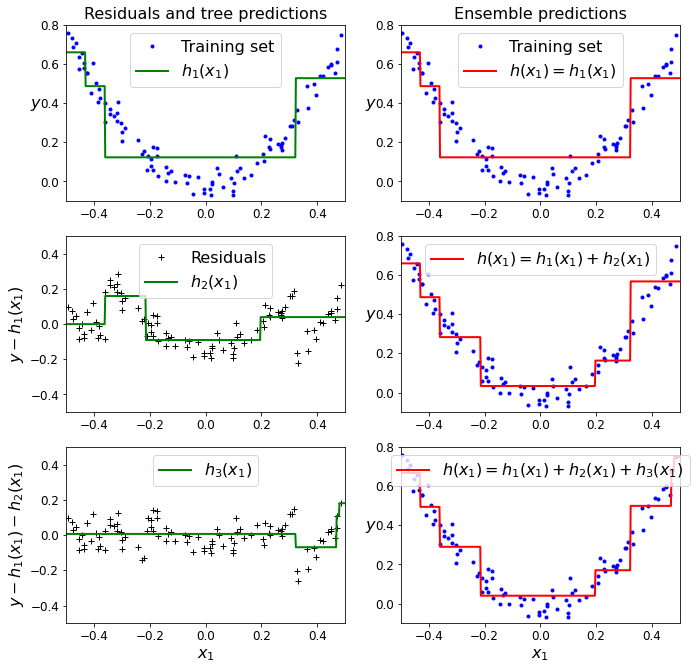

In [ ]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

트리가 앙상블에 추가될수록 앙상블의 예측이 점차 좋아진다.  
사이킷런의 GradientBoostingRegressor를 사용하면 GBRT 앙상블을 간단하게 훈련시킬 수 있다.  


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth = 2, n_estimators = 3, learning_rate = 1.0, random_state = 42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [ ]:
# <그림 7-10. 예측기가 부족한 경우와 너무 많으 경우의 GBRT 앙상블> 생성 코드

gbrt_slow = GradientBoostingRegressor(max_depth =  2, n_estimators = 200, learning_rate = 0.1, random_state = 42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

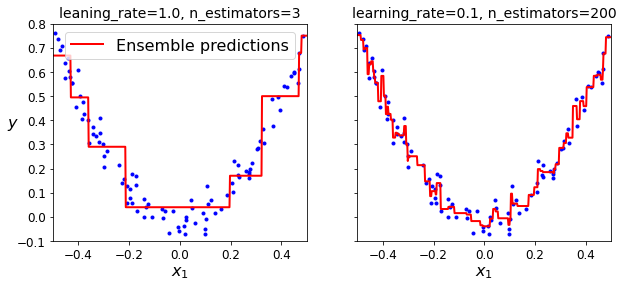

In [ ]:
fig, axes = plt.subplots(ncols = 2, figsize = (10, 4), sharey = True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes = [-0.5, 0.5, -0.1, 0.8], label = "Ensemble predictions")
plt.title("leaning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize = 14)
plt.xlabel("$x_1$", fontsize = 16)
plt.ylabel("$y$", fontsize = 16, rotation = 0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes = [-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize = 14)
plt.xlabel("$x_1$", fontsize = 16)

plt.show()

트리 수가 너무 많으면 훈련 세트에 과대적합한다.

In [ ]:
# 최적의 트리 수를 찾기 위해 각 훈련 단계에서 검증 오차를 측정한다.

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 42)

gbrt = GradientBoostingRegressor(max_depth = 2, n_estimators = 120, random_state = 42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
            for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth = 2, n_estimators = bst_n_estimators, random_state = 42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=118, random_state=42)

In [ ]:
# 조기 종료를 사용하여 트리 수 튜닝

min_error = np.min(errors)

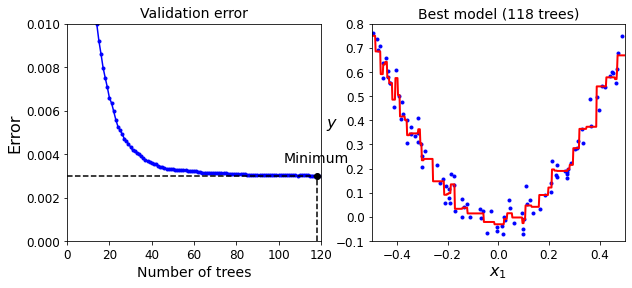

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

In [ ]:
# 어느 정도 유예를 갖는 조기 종료 (5 에포크 동안 향상되지 않을 때만 훈련 중지)

gbrt = GradientBoostingRegressor(max_depth = 2, warm_start = True, random_state = 42)

min_val_error = float("inf")
error_gonig_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_gonig_up = 0
    else:
        error_gonig_up += 1
        if error_gonig_up == 5:
            break  # 조기종료

In [ ]:
print(gbrt.n_estimators)

105


In [ ]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.003023701609089896


**XGBoost**

In [ ]:
try:
    import xgboost
except importError as ex:
    print("에러: xgboost 라이브러리 설치 안됨")
    xgboost = None

In [ ]:
if xgboost is not None:
    xgb_reg = xgboost.XGBRegressor(random_state = 42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    print("Validation MSE:", val_error)

Validation MSE: 0.0030701301701716146


In [ ]:
if xgboost is not None:
    xgb_reg.fit(X_train, y_train,
                eval_set = [(X_val, y_val)], early_stopping_rounds = 2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    print("Validation MSE:", val_error)

[0]	validation_0-rmse:0.19678
[1]	validation_0-rmse:0.14325
[2]	validation_0-rmse:0.10835
[3]	validation_0-rmse:0.08482
[4]	validation_0-rmse:0.07044
[5]	validation_0-rmse:0.06255
[6]	validation_0-rmse:0.05927
[7]	validation_0-rmse:0.05698
[8]	validation_0-rmse:0.05519
[9]	validation_0-rmse:0.05513
[10]	validation_0-rmse:0.05473
[11]	validation_0-rmse:0.05463
[12]	validation_0-rmse:0.05427
[13]	validation_0-rmse:0.05376
[14]	validation_0-rmse:0.05377
[15]	validation_0-rmse:0.05363
[16]	validation_0-rmse:0.05358
[17]	validation_0-rmse:0.05387
Validation MSE: 0.0028706534131390338


In [ ]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

60.7 ms ± 1.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

17.6 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## 연습문제

### 8. 
MNIST 데이터를 불러들여 훈련 세트, 검증 세트, 테스트 세트로 나눈다.  
그런 다음 랜덤 포레스트 분류기, 엑스트라 트리 분류기, svm 분류기 같은 여러 종류의 분류기를 훈련시킨다.  
그리고 검증 세트에서 개개의 분류기보다 더 높은 성능을 내도록 이들을 간접 또는 직접 투표 방법을 사용해 앙상블로 연결해라.  
앙상블을 얻고나면 테스트 세트로 확인해 봐라.  
개개의 분류기와 비교해서 성능이 얼마나 향상되는가? 

In [ ]:
# MNIST 데이터를 불러들여 훈련 세트, 검증 세트, 테스트 세트로 나눈다.

from sklearn.model_selection import train_test_split

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(mnist.data, mnist.target, test_size = 10000, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 10000, random_state = 42)

In [ ]:
# 랜덤 포레스트 분류기, 엑스트라 트리 분류기, SVM 같은 여러 종류의 분류기를 훈련시킨다.

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [ ]:
random_forest_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
extra_trees_clf = ExtraTreesClassifier(n_estimators = 100, random_state = 42)
svm_clf = LinearSVC(max_iter = 100, tol = 20, random_state = 42)
mlp_clf = MLPClassifier(random_state = 42)

In [ ]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(random_state=42)
Training the ExtraTreesClassifier(random_state=42)
Training the LinearSVC(max_iter=100, random_state=42, tol=20)
Training the MLPClassifier(random_state=42)


In [ ]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9692, 0.9715, 0.859, 0.9626]

선형 svm이 다른 분류기보다 성능이 많이 떨어진다.  
그러나 투표 기반 분류기의 성능을 향상시킬 수 있으므로 그대로 둔다.

In [ ]:
# 검증 세트에서 개개의 분류기보다 더 높은 성능을 내도록 이들을 간접 또는 직접 투표 분류기를 사용하는 앙상블로 연결한다

from sklearn.ensemble import VotingClassifier

In [ ]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf)
]

In [ ]:
voting_clf = VotingClassifier(named_estimators)

In [ ]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf',
                              LinearSVC(max_iter=100, random_state=42, tol=20)),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [ ]:
voting_clf.score(X_val, y_val)

0.9702

훈련 세트로 모델을 훈련하고 => 검증 세트로 성능 점수 !

In [ ]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.9692, 0.9715, 0.859, 0.9626]

In [ ]:
# svm 모델을 제거해서 성능이 향상되는지 확인해 본다.
# 아래와 같이 set_params()를 사용하여 None으로 지정하면 특정 예측기를 제외시킬 수 있다.

voting_clf.set_params(svm_clf = None)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf', None),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [ ]:
# 예측기 목록기 바뀐 것을 확인할 수 있다

voting_clf.estimators

[('random_forest_clf', RandomForestClassifier(random_state=42)),
 ('extra_trees_clf', ExtraTreesClassifier(random_state=42)),
 ('svm_clf', None),
 ('mlp_clf', MLPClassifier(random_state=42))]

In [ ]:
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 LinearSVC(max_iter=100, random_state=42, tol=20),
 MLPClassifier(random_state=42)]

하지만 훈련된 예측기 목록은 업데이트되지 않은 것을 확인할 수 있다.

In [ ]:
# VotingClassifier를 다시 훈련시키거나 그냥 훈련된 예측기 목록에서 svm 모델을 제거할 수 있다.
del voting_clf.estimators_[2]

In [ ]:
# VotingClassifier를 다시 평가해 본다.

voting_clf.voting = "soft"

In [ ]:
voting_clf.score(X_val, y_val)

0.9699

In [ ]:
# 테스트 세트로 확인해본다.
# 개개의 분류기와 비교해서 성능이 얼마나 향상되었나

voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)

0.9701

In [ ]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.9645, 0.9691, 0.9607]

여기서는 투표 기반 분류기가 최선의 모델의 오차율을 아주 조금만 감소시킨다.

### 9.
이전 연습문제의 각 분류기를 실행해서 검증 세트에서 예측을 만들고 그 결과로 새로운 훈련 세트를 만들어보세요. 각 훈련 샘플은 하나의 이미지에 대한 전체 분류기의 예측을 담은 벡터고 타깃은 이미지의 클래스입니다. 새로운 훈련 세트에 분류기 하나를 훈련시켜 보세요.

In [ ]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype = np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [ ]:
X_val_predictions

array([[5., 5., 5., 5.],
       [8., 8., 8., 8.],
       [2., 2., 3., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

In [ ]:
rnd_forest_blender = RandomForestClassifier(n_estimators = 200, oob_score = True, random_state = 42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [ ]:
rnd_forest_blender.oob_score_

0.9683

이 블렌더를 세밀하게 튜닝하거나 다른 종류의 블렌더(예를 들어, MLPClassifier)를 시도해 볼 수 있습니다. 그럼 늘 하던대로 다음 교차 검증을 사용해 가장 좋은 것을 선택합니다.

문제: 축하합니다. 방금 블렌더를 훈련시켰습니다. 그리고 이 분류기를 모아서 스태킹 앙상블을 구성했습니다. 이제 테스트 세트에 앙상블을 평가해보세요. 테스트 세트의 각 이미지에 대해 모든 분류기로 예측을 만들고 앙상블의 예측 결과를 만들기 위해 블렌더에 그 예측을 주입합니다. 앞서 만든 투표 분류기와 비교하면 어떤가요?

In [ ]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype = np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [ ]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_test, y_pred)

0.9687

이 스태킹 앙상블은 앞서 만든 투표 기반 분류기만큼 성능을 내지는 못한다.  
최선의 개별 분류기만큼 뛰어나지는 않다.